In [14]:
import requests
import os
from tqdm import tqdm
import json
import re
import emoji
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [15]:
def calculate_metrics(y_true, y_pred, field_name, modifier = lambda x: x):
    y_true_field = [modifier(y[field_name]) for y in y_true]
    y_pred_field = [modifier(y[field_name]) for y in y_pred]
    return metrics.classification_report(y_true_field, y_pred_field, digits=3)

def compare_intervals(interval1, interval2):
    intervals1 = interval1.split(';')
    intervals2 = interval2.split(';')
    
    interval1_set = []
    interval2_set = []
    
    if len(intervals1) > 0 or intervals1[0] == '':
        for interval in intervals1:
            try:
                splitted_interval = interval.split('..')
                start = int(splitted_interval[0])
                end = int(splitted_interval[1])
                interval1_set.extend(range(start, end))
            except:
                a = 1
        
    if len(intervals2) > 0 or intervals2[0] == '':
        for interval in intervals2:
            try:
                splitted_interval = interval.split('..')
                start = int(splitted_interval[0])
                end = int(splitted_interval[1])
                interval2_set.extend(range(start, end))
            except:
                a = 1
        
    interval1_set = set(interval1_set)
    intersection = interval1_set.intersection(interval2_set)
    return len(interval1_set), len(interval2_set), len(intersection)
            

def evaluate(parsed, annotation):
    annotation_length = sum(len(v) for v in annotation.values())
    parsed_length = sum(len(v) for v in parsed.values())
    connective_match = 0
    sense1_match = 0
    sense2_match = 0
    type_match = 0
    arg1_match = 0
    arg2_match = 0
    arg1_total_parsed_length = 0
    arg1_total_annotated_length = 0
    arg2_total_parsed_length = 0
    arg2_total_annotated_length = 0
    arg1_intersection = 0
    arg2_intersection = 0
    pred = []
    treu = []
    results = []
    
    for p_file_key in parsed.keys():
        all_keys = np.concatenate((
            list(parsed[p_file_key].keys()) or [],
            list(annotation.get(p_file_key).keys()) or []
        ))
        for key in all_keys:
            cur_result = dict()
    
    for p_file_key in parsed.keys():
        for p_connective_key in parsed[p_file_key].keys():
            cur_ann = annotation.get(p_file_key)
            if not cur_ann:
                break
            if p_connective_key in cur_ann.keys():
                cur_result = dict()
                cur_result['file_key'] = p_file_key
                cur_result['connective_key'] = p_connective_key
                connective_match += 1
                cur_annotation_relation = cur_ann[p_connective_key]
                cur_parsed_relation = parsed[p_file_key][p_connective_key]
                pred.append(cur_parsed_relation)
                treu.append(cur_annotation_relation)
                # sense
                a_sense = cur_annotation_relation['sense'].split('.')
                p_sense = cur_parsed_relation['sense'].split('.')
                if a_sense[0] == p_sense[0]:
                    sense1_match += 1
                    if a_sense[1] == p_sense[1]:
                        sense2_match += 1
                cur_result['a_sense_1'] = a_sense[0]
                cur_result['p_sense_1'] = p_sense[0]
                cur_result['a_sense_2'] = '.'.join(a_sense[:2])
                cur_result['p_sense_2'] = '.'.join(p_sense[:2])
                cur_result['sense_1_match'] = a_sense[0] == p_sense[0]
                cur_result['sense_2_match'] = '.'.join(a_sense[:2]) == '.'.join(p_sense[:2])
                
                # type
                a_type = cur_annotation_relation['type']
                p_type = cur_parsed_relation['type']
                if a_type == p_type:
                    type_match += 1
                cur_result['a_type'] = a_type
                cur_result['p_type'] = p_type
                cur_result['type_match'] = a_type == p_type
                    
                # arg1
                a_arg1 = cur_annotation_relation['arg1_range']
                p_arg1 = cur_parsed_relation['arg1_range']
                ## exact match
                if a_arg1 == p_arg1:
                    arg1_match += 1
                ## partial match
                _a1, _p1, _i1 = compare_intervals(a_arg1, p_arg1)
                arg1_total_annotated_length += _a1
                arg1_total_parsed_length += _p1
                arg1_intersection += _i1
                
                cur_result['a_arg1_length'] = _a1
                cur_result['p_arg1_length'] = _p1
                cur_result['arg1_match'] = _i1
                    
                # arg2
                a_arg2 = cur_annotation_relation['arg2_range']
                p_arg2 = cur_parsed_relation['arg2_range']
                ## exact match
                if a_arg2 == p_arg2:
                    arg2_match += 1
                ## partial match
                _a2, _p2, _i2 = compare_intervals(a_arg2, p_arg2)
                arg2_total_annotated_length += _a2
                arg2_total_parsed_length += _p2
                arg2_intersection += _i2
                
                cur_result['a_arg2_length'] = _a2
                cur_result['p_arg2_length'] = _p2
                cur_result['arg2_match'] = _i2
                
                results.append(cur_result)
    
    result = ''                
    result += str(calculate_metrics(treu, pred, 'sense', lambda sense: sense.split('.')[0]))
    result += '\n'
    result += str(calculate_metrics(treu, pred, 'sense', lambda sense: '.'.join(sense.split('.')[:2])))
    result += '\n'
    result += str(calculate_metrics(treu, pred, 'type'))
    result += '\n'
                
    result += 'annotated relations: ' + str(annotation_length)
    result += '\n'
    result += 'parsed relations: ' + str(parsed_length)
    result += '\n'
    result += 'connective match: ' + str(connective_match)
    result += '\n'
    result += 'sense lvl1 match: ' + str(sense1_match)
    result += '\n'
    result += 'sense lvl2 match: ' + str(sense2_match)
    result += '\n'
    result += 'type match: ' + str(type_match)
    result += '\n'
    result += 'arg1 match: ' + str(arg1_match)
    result += '\n'
    result += 'arg2 match: ' + str(arg2_match)
    result += '\n'
    result += 'args partial match: '
    result += '\n'
    result += 'arg1 char match: ' + str(arg1_intersection)
    result += '\n'
    result += 'arg1 annotated total: ' + str(arg1_total_annotated_length)
    result += '\n'
    result += 'arg1 parsed total: ' + str(arg1_total_parsed_length)
    result += '\n'
    result += 'arg2 char match: ' + str(arg2_intersection)
    result += '\n'
    result += 'arg2 annotated total: ' + str(arg2_total_annotated_length)
    result += '\n'
    result += 'arg2 parsed total: ' + str(arg2_total_parsed_length)
    result += '\n'
    
    print(result)
    return results

def get_comparison_dict(parsed, annotation):
    results = []
    
    for p_file_key in parsed.keys():
        cur_p_file = parsed.get(p_file_key)
        cur_a_file = annotation.get(p_file_key)
        all_keys = np.concatenate((
            list(cur_p_file.keys()) if p_file_key in parsed.keys() else [], 
            list(cur_a_file.keys()) if p_file_key in annotation.keys() else []
        ))
        all_keys = np.unique(all_keys)
        for connective_key in all_keys:
            cur_result = dict()
            cur_result['file_key'] = p_file_key
            cur_result['connective_key'] = connective_key
            cur_result['a_exists'] = connective_key in cur_a_file if cur_a_file else False
            cur_result['p_exists'] = connective_key in cur_p_file if cur_p_file else False
            
            if cur_result['a_exists']:
                cur_a_relation = annotation[p_file_key][connective_key]
                
                a_sense = cur_a_relation['sense'].split('.')
                cur_result['a_sense_1'] = a_sense[0]
                cur_result['a_sense_2'] = '.'.join(a_sense[:2])
                
                a_type = cur_a_relation['type']
                cur_result['a_type'] = a_type
                
                a_arg1 = cur_a_relation['arg1_range']
                cur_result['a_arg1_range'] = a_arg1
                
                a_arg2 = cur_a_relation['arg2_range']
                cur_result['a_arg2_range'] = a_arg2
                
            if cur_result['p_exists']:
                cur_p_relation = parsed[p_file_key][connective_key]
                
                p_sense = cur_p_relation['sense'].split('.')
                cur_result['p_sense_1'] = p_sense[0]
                cur_result['p_sense_2'] = '.'.join(p_sense[:2])
                
                p_type = cur_p_relation['type']
                cur_result['p_type'] = p_type
                
                p_arg1 = cur_p_relation['arg1_range']
                cur_result['p_arg1_range'] = p_arg1
                
                p_arg2 = cur_p_relation['arg2_range']
                cur_result['p_arg2_range'] = p_arg2
            results.append(cur_result)
    return results

def draw_confusion_matrix(df, column):
    labels = np.unique(list(df['a_' + column]) + list(df['p_' + column]))
    matrix = confusion_matrix(df['a_' + column], df['p_' + column], labels=labels)
    df_cm = pd.DataFrame(matrix, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (12,12))
    sn.heatmap(df_cm, annot=True, cmap='Reds', fmt='g')


In [16]:
def parse_file(file_path):
    files = {'input': open(file_path, 'rb')}

    r = requests.post('http://localhost:5500/parse', files=files)
    return r

def to_annotation_format(span_list):
    return ';'.join('..'.join(map(str, r)) for r in span_list)

def to_plain_result(result):
    arg1 = result['Arg1']['RawText']
    arg1_range = to_annotation_format(result['Arg1']['CharacterSpanList'])
    arg2 = result['Arg2']['RawText']
    arg2_range = to_annotation_format(result['Arg2']['CharacterSpanList'])
    connective = result['Connective']['RawText']
    connective_range = to_annotation_format(result['Connective']['CharacterSpanList'])
    sense = result['Sense']
    typ = result['Type']
    result_plain = {
        'arg1': arg1,
        'arg1_range': arg1_range,
        'arg2': arg2,
        'arg2_range': arg2_range,
        'connective': connective,
        'connective_range': connective_range,
        'sense': sense,
        'type': typ
    }
    return result_plain

def parse_result(file_name):
    result = json.loads(files_tweets[file_name])
    parsed_results = []
    for item in result:
        parsed_results.append(to_plain_result(item))
    return parsed_results

def parse_annotation(input_file_path, annotated_file_path):
    annotations = []
    with open(input_file_path, encoding="utf8") as input_file:
        with open(annotated_file_path) as ann_file:
                file_content = input_file.read()
                for line in ann_file:

                    properties = line.split('|')
                    typ = properties[0]
                    connective_ranges = None
                    connective = None
                    if typ == 'Explicit':
                        connective_ranges = properties[1]
                        connective = extract_from_ranges_16(file_content, connective_ranges)
                    if typ == 'Implicit':
                        connective_ranges = properties[31]
                    sense = properties[8]
                    arg1_range = properties[14]
                    arg2_range = properties[20]
                    arg1 = extract_from_ranges_16(file_content, arg1_range)
                    arg2 = extract_from_ranges_16(file_content, arg2_range)
                    result = {
                        'arg1_range': arg1_range,
                        'arg2_range': arg2_range,
                        'arg1': arg1,
                        'arg2': arg2,
                        'connective_range': connective_ranges,
                        'connective': connective,
                        'sense': sense,
                        'type': typ
                    }
                    annotations.append(result)
    return annotations

def is_unwanted(word):
    if is_handle(word):
        return True
    if is_url(word):
        return True
    return False

def is_handle(word):
    return word[0] == '@'

def is_url(word):
    return re.match(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', word) 
            
            
def extract_from_ranges_16(file_content, rangs):
    file_content = file_content.encode('utf-16le')
    text = []
    for rang in rangs.split(';'):
        if len(rang) < 2:
            return ''
        splitted = rang.split('..')
        word = file_content[int(splitted[0]) * 2: int(splitted[1]) * 2].decode('utf-16le')
        text.append(word)
    return ' '.join(text)

## for some reason emojies take 2 spaces in the annotation files. therefore I am appending every emoji a space
def deemojify(text):
    return ''.join(modify_emoji(c) for c in text)
    
def modify_emoji(c):
    if c in emoji.UNICODE_EMOJI['en'].keys():
        print(c)
        return c + ' '
    else:
        return c

In [17]:
### parses the files in the folder and writes them in a json called parsed_tweets.json
def parse_threads(folder):
    ### get file names
    files = []
    try: 
        files = os.listdir(folder + '/ann/')
    except:
        files = os.listdir(folder + '/threads/')
    
    ### send request to linparser to parse the files
    parsed_tweets = dict()

    for file in tqdm(files):
        try:
            parsed_tweets[file] = parse_file(folder + '/threads/' + file).text
        except FileNotFoundError:
            print('File not found:', file)

    files_tweets = dict()
    for file in files:
        _parsed = parsed_tweets.get(file)
        if _parsed:
            files_tweets[file] = parsed_tweets[file]

    with open(folder + '/parsed_tweets.json', 'w') as file:
        file.write(json.dumps(files_tweets))

    plain_parsed = dict()
    errors = []
    with open(folder + '/parsed_tweets.json', 'r') as new_file:
            obj = json.loads(new_file.read())
            for file in obj.keys():
                try:
                    cur_parsed = dict()
                    for output in json.loads(obj[file]):
                        result = to_plain_result(output)
                        cur_parsed[result['connective_range']] = result
                    plain_parsed[file] = cur_parsed
                except Exception as err:
                    errors.append(err)
                    print('error for some reason!')

    with open(folder + '/parsed.json', 'w+', encoding='utf8') as new_file:
        new_file.write(json.dumps(plain_parsed))

### parse annotations into readable jsons
def parse_annotations(folder):
    readable_annotations = dict()
    ### get file names
    files = os.listdir(folder + '/ann/')
    
    for file in files:
        try: 
            readable_annotations[file] = dict()
            for annotation in parse_annotation(
                folder + '/threads/' + file,
                folder + '/ann/' + file,
            ):
                _id = annotation['connective_range']
                readable_annotations[file][_id] = annotation
        except FileNotFoundError as inst:
            print(file, type(inst))

    with open(folder + '/annotations.json', 'w+', encoding='utf8') as new_file:
        new_file.write(json.dumps(readable_annotations))
        
def draw_graphs(plain_parsed, plain_annotated):
    all_results = get_comparison_dict(plain_parsed, plain_annotated)
    df = pd.DataFrame.from_dict(all_results)
    df = df[~(df['a_type'] == 'Hypophora')]
    df = df.fillna('Not Found')

    ## arg match calculation

    arg1_comp = df.apply(lambda row: compare_intervals(row.a_arg1_range, row.p_arg1_range), axis=1)
    arg2_comp = df.apply(lambda row: compare_intervals(row.a_arg2_range, row.p_arg2_range), axis=1)
    # df['a_arg1_length'], df['p_arg1_length'], df['arg1_match'] = df.apply(lambda row: compare_intervals(row.a_arg1_range, row.p_arg1_range), axis=1)
    # df['a_arg2_length'], df['p_arg2_length'], df['arg2_match'] = df.apply(lambda row: compare_intervals(row.a_arg2_range, row.p_arg2_range), axis=1)
    df['a_arg1_length'] = [row[0] for row in arg1_comp.values]
    df['p_arg1_length'] = [row[1] for row in arg1_comp.values]
    df['arg1_match'] = [row[2] for row in arg1_comp.values]
    df['arg1_recall'] = df['arg1_match'] / df['p_arg1_length']
    df['arg1_precision'] = df['arg1_match'] / df['a_arg1_length']
    df['a_arg2_length'] = [row[0] for row in arg2_comp.values]
    df['p_arg2_length'] = [row[1] for row in arg2_comp.values]
    df['arg2_match'] = [row[2] for row in arg2_comp.values]
    df['arg2_recall'] = df['arg2_match'] / df['p_arg2_length']
    df['arg2_precision'] = df['arg2_match'] / df['a_arg2_length']
    draw_confusion_matrix(df, 'exists')
    draw_confusion_matrix(df, 'type')
    draw_confusion_matrix(df, 'sense_1')
    draw_confusion_matrix(df, 'sense_2')
    print(df[['arg1_precision','arg1_recall','arg2_precision','arg2_recall']].mean())
        
def evaluate_folder(folder):
    if not os.path.isfile(folder + '/parsed.json'):
        parse_threads(folder)
    parse_annotations(folder)

    plain_annotated = None
    with open(folder + '/annotations.json', 'r') as f:
        plain_annotated = json.loads(f.read())

    plain_parsed = None
    with open(folder + '/parsed.json', 'r') as f:
        plain_parsed = json.loads(f.read())
        
    evaluate(plain_parsed, plain_annotated)
    draw_graphs(plain_parsed, plain_annotated)

              precision    recall  f1-score   support

  Comparison      0.971     0.906     0.938       224
 Contingency      0.954     0.798     0.869       287
   Expansion      0.804     0.959     0.875       197
    Temporal      0.683     0.851     0.758       114
   Undecided      0.000     0.000     0.000         4

    accuracy                          0.869       826
   macro avg      0.683     0.703     0.688       826
weighted avg      0.881     0.869     0.870       826

                                 precision    recall  f1-score   support

          Comparison.Concession      0.857     0.029     0.056       208
            Comparison.Contrast      0.035     0.583     0.065        12
          Comparison.Similarity      0.000     0.000     0.000         4
              Contingency.Cause      0.778     0.875     0.824       128
       Contingency.Cause+Belief      0.000     0.000     0.000        22
    Contingency.Cause+SpeechAct      0.000     0.000     0.000         3

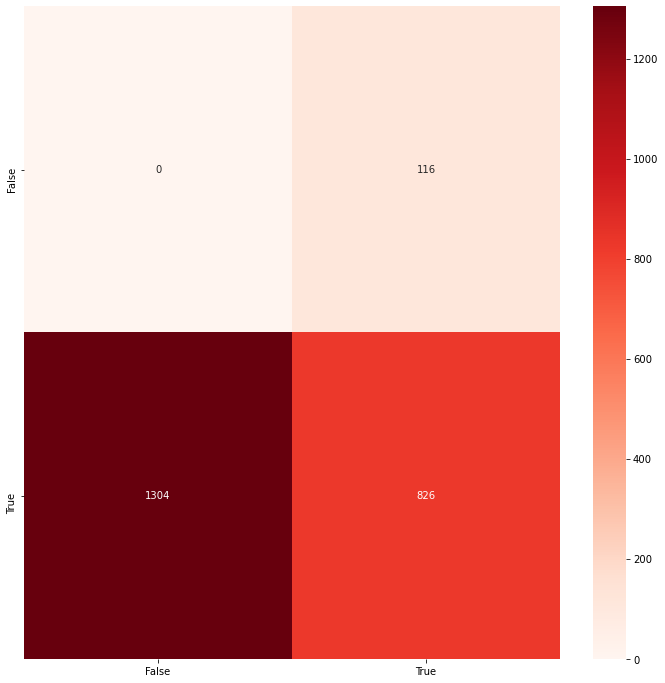

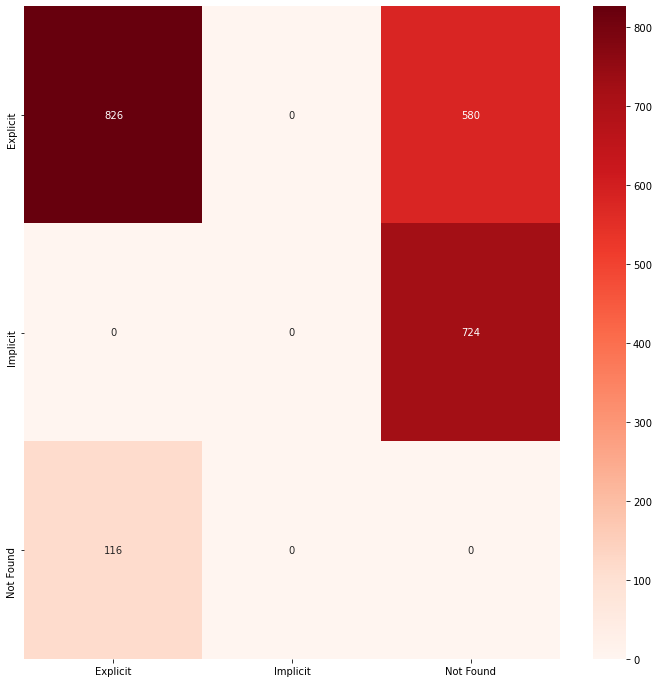

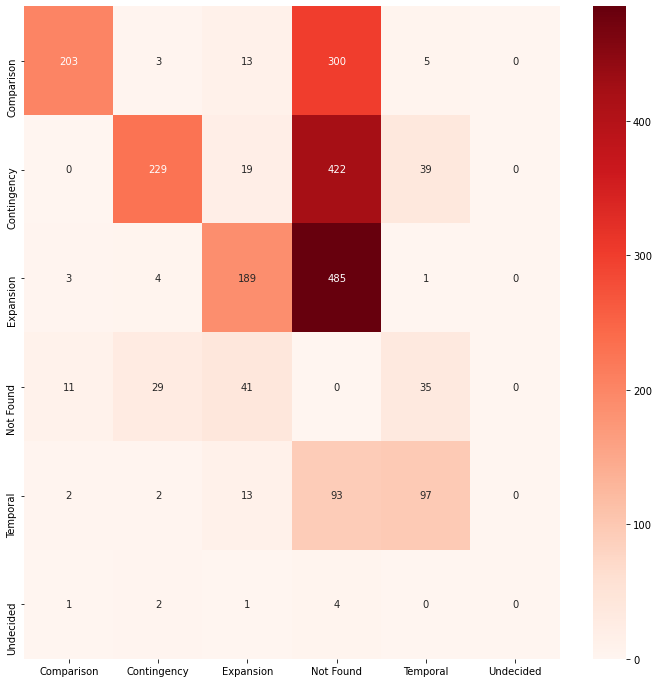

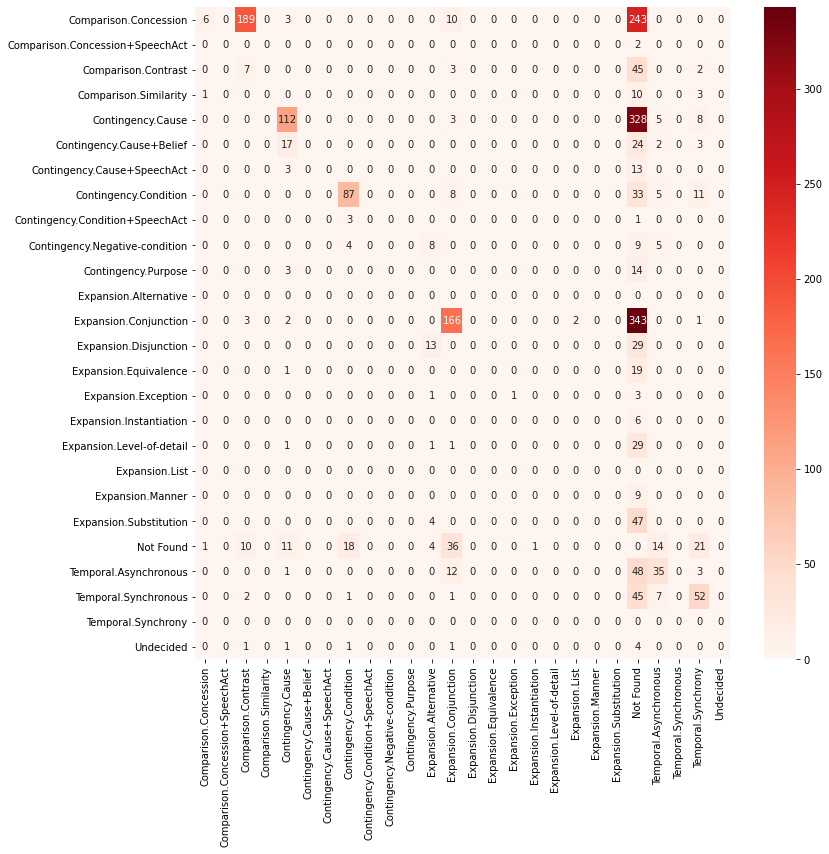

In [18]:
evaluate_folder('data/tw_data/PDTB_Annotations_20200205__/preprocessed_with_points')

In [35]:
evaluate_folder('data/tw_data/PDTB_Annotations_20200205__/preprocessed')

  0%|          | 0/185 [00:00<?, ?it/s]

?


100%|██████████| 185/185 [18:32<00:00,  6.02s/it]

error for some reason!


FileNotFoundError: [Errno 2] No such file or directory: 'data/tw_data/PDTB_Annotations_20200205__/preprocessed/ann/'

In [42]:
parse_annotations('data/tw_data/PDTB_Annotations_20200205__/preprocessed_with_points')

028_948124816611139589.branch318.txt.username_text_tabseparated
and
Conor is Khabib hardest fight
Khabib is Conors hardest fight
like
Did you see Khabib walk through Barbosa's spinning kick
nothing happened?
Did you see Khabib walk through Barbosa's spinning kick like nothing happened?
Didn’t land clean
Did you see Khabib walk through Barbosa's spinning kick like nothing happened?
Didn’t land clean
Didn’t land clean
There was enough power behind the kick to cause damage but Khabib is tough so he just soldiered on.
but
There was enough power behind the kick to cause damage
Khabib is tough so he just soldiered on.
so
There was enough power behind the kick to cause damage but Khabib is tough
he just soldiered on.
but
He did say after the fight that Edson kicks hurt
he kept going.
he kept going.
I think any other fighter would have taken a step back or become cautious and defensive.
or
any other fighter would have taken a step back
become cautious and defensive.
any other fighter would hav

Many religious people aren’t afraid of acceptance but if that’s what some people believe then let them be!
Don’t make it seem like all religious people are like that!!
Because
Don’t make it seem like all religious people are like that!!
they’re not!
if
he would get A LOT more backlash
he said outright "I dont like gay marriage because I believe gay people shouldn't be allowed the same rights as me"
because
I dont like gay marriage
I believe gay people shouldn't be allowed the same rights as me
but
if he said outright "I dont like gay marriage because I believe gay people shouldn't be allowed the same rights as me" he would get A LOT more backlash
I'd have more respect for him because at least then he would be owning the hate he's spreading
because
I'd have more respect for him
at least then he would be owning the hate he's spreading
Well he ain’t wrong.
I respect him for standing for his belief.
I respect him for standing for his belief.
Gay marriage isn’t a marriage.
He isn't standing

it could go either way
Nerf Cortex,
not him.
056_950079679213563905.branch25.txt.username_text_tabseparated
for
MARK YOURE UNDER ARREST FOR THE 10TH TIME NOW
being gay for nagito?
NAGITO KILLED CHIAKI
HE CAN NEVER REPAY FOR THAT
but
nagito was trying to save her,
failed
also
nagito was trying to save her, but failed
RL chiaki was killed by chise pretty sure
so
actually, she kinda did that herself, nagito was trying to save her, but failed, also RL chiaki was killed by chise pretty sure,
no youre wrong
100_950307666428968960.branch11.txt.username_text_tabseparated
and
I just remembered being a kid after seeing Superman '78
how much I loved and *emulated* Lex Luthor
and
I quoted his dialog
tried to act like him.
when
I loved bad guys
I was a kid!
I did the same thing with the Batman Animated Series in the 90's.
The villains were so well written.
TAS remains to me the best rendition of Batman, just for that reason.
I like how the Arkham games were the successor of that series.
510_9463509

though
I prefered the psychedelic indie pop from their earlier works.
Beetlebum is great
The stuff after Parklife is a lot less conventional
it starts to get weird
but
it starts to get weird
in a good way
but
I agree
it really kind of shares the same feel as the track that Jay shared
but
I think that is a stretch
Country Sad is my favorite song on that record.
Country Sad is my favorite song on that record.
I like Damon's projects.
but
It's not my fave stuff
I see the similarities.
015_947317600362684416.branch708.txt.username_text_tabseparated
That whole article and its RIS writer has been debunked long ago.
Run along troll.
documentation?
I trust the Guardian more than I trust random rude guy on Twitter.
She is 3 months ahead of news.
The Guardian will publish hit pieces from non reporters if it fits their narrative.
if
The Guardian will publish hit pieces from non reporters
it fits their narrative.
The Guardian will publish hit pieces from non reporters if it fits their narrative.
S

190_950380522152316928.branch11.txt.username_text_tabseparated
Modern western life is DEPRESSING.
No amount of drugs will change that.
No amount of drugs will change that.
That said, I'm still on antidepressants.
keep taking your SSRIs.
I take mine.
But
keep taking your SSRIs. I take mine.
you have to figure out what is REALLY causing your depression and deal with that.
and
figure out what is REALLY causing your depression
deal with that.
If
being on antidepressants doesn’t change the fact you’re married to an abusive spouse.
you’re married to an abusive spouse
Why isn’t neurochemistry sufficient?
If, for example, you’re married to an abusive spouse, being on antidepressants doesn’t change the fact you’re married to an abusive spouse.
Why isn’t neurochemistry sufficient?
If, for example, you’re married to an abusive spouse, being on antidepressants doesn’t change the fact you’re married to an abusive spouse.
being on antidepressants doesn’t change the fact you’re married to an abusive 

scroll down to Building from source
find Mac.
if
i try the build the latest github source
maybe if i try the build the latest github source ?
Yes, that is how I did.
Run your build commands ./building/common.sh ./building/mac/requirements.sh ./building/mac/build.sh
can you post the build command?
do i have to install qt-opensource-mac-x64-clang-5.5.0 also ?
It is already in build command, I think in requirments.sh
Things like this will get better
Enhancements will be pushed over the next couple of weeks.
and
I downloaded the blockchain data
dumpit
and
I downloaded the blockchain data and dumpit
just waiting to sync but it doesn't move for now
but
just waiting to sync
it doesn't move for now
waiting to sync but it doesn't move for now
Sync is in background.
Sync is in background.
You need to open debug.log from application support folder or u can do it over help in top navigation bar in Verge-QT
or
You need to open debug.log from application support folder
u can do it over help in top n

we may follow up on the transaction.
551_949553013709930498.branch1.txt.username_text_tabseparated
if
you wont charge cancellation fee for the booking which i made today and hve to cancel.
you have even iota of customer centricity left,
and
i made today
hve to cancel
though
if you have even iota of customer centricity left, you wont charge cancellation fee for the booking which i made today and hve to cancel.
Fyi i made another booking in different hotel
and
The hotel handles cancellation charges directly
in 2 cases they gave me a refund.
In my case it was lil different.
the hotel guy told me booking dot com has rights to deduct cancellation and that the hotel wont charge for it.
and
booking dot com has rights to deduct cancellation
that the hotel wont charge for it.
booking dot com has rights to deduct cancellation and that the hotel wont charge for it.
Its booking dot com's discretion.
though
Its booking dot com's discretion.
I found that weird
043_949966884820090880.branch1200.txt.u

until
Oprah Winfrey was basically his pimp up
they all got caught
Oprah Winfrey was basically his pimp up until they all got caught
this doesn’t pass the smell test
134_950355508925407232.branch1.txt.username_text_tabseparated
If
Let's talk about chess with me!
you are free,
Who do you think is better Fischer or Carlsen
The only one who can stop Magnus is Nakamura. I think so. But he never won a classical time control against Magnus.
But
The only one who can stop Magnus is Nakamura.
he never won a classical time control against Magnus.
How can I become a ChessMaster?
Don't worry yourself about that!
and
What made you go on Twitter
talk about chess?
What made you go on Twitter and talk about chess?
Not knowing, I cannot say.
007_946503468155486208.branch13.txt.username_text_tabseparated
Luke Bryan Gifted His Wife 2 Kangaroos For Christmas
Here’s Why This is a Horrible Idea
Kangaroo are not Pets
they are Wildlife who belong here in Australia in the Wild,
Kangaroo are not Pets they are Wi